# [nobrainer](https://github.com/neuronets/nobrainer)

A framework for developing neural network models for 3D image processing.

Nobrainer includes guide notebooks on its GitHub page. This notebook is different in that it combines several concepts into a single notebook.

If you come across any issues or ways to improve nobrainer, please submit an [issue](https://github.com/neuronets/nobrainer/issues) or [pull request](https://github.com/neuronets/nobrainer/pulls).

See pre-trained models at https://github.com/neuronets/nobrainer-models, https://github.com/neuronets/kwyk, and https://github.com/neuronets/ams.

# This notebook

**Lots of breadth, some depth.**

We will...
1. Learn how to visualize MRI data prior to model training
2. Learn how to process features for model training
3. Train a brain extraction model
4. Use a pre-trained nobrainer model for brain extraction and another for multi-class segmentation.
5. Understand the parts of a real-world deep learning workflow
6. Use nobrainer to construct that workflow and train a brain-extraction model using transfer learning.

The vast majority of this can be done on your personal laptop with a CPU (no GPU required). There are two parts in which you would benefit from a GPU (for model training), but the outputs are pasted in those sections in case you do not have a GPU.

# Wisdom

- Garbage in, garbage out
- Deep learning is not a hammer -- it is not always the right tool for the job
- Be patient -- you _will_ run into errors and difficulties
- Be collaborative -- if you find ways to improve Nobrainer, submit an [issue](https://github.com/neuronets/nobrainer/issues) or [pull request](https://github.com/neuronets/nobrainer/pulls)

## Google Colaboratory

Notebooks can be for free on Google Colaboratory (you must be signed into a Google account). If you are using Colab, please note that multiple open tabs of Colab notebooks will use the same resources (RAM, GPU). Downloading data in multiple Colab notebooks at the same time or training multiple models can quickly exhaust the available resources. For this reason, please run one notebook at a time, and keep an eye on the resources used.

Users can choose to run Colab notebooks on CPU, GPU, or TPU. By default, the notebooks will use the CPU runtime. To use a different runtime, please select `Runtime > Change runtime type` in the menu bar. Then, choose either `GPU` or `TPU` under `Hardware accelerator`. No code changes are required when running on CPU or GPU runtime. When using the TPU runtime, however, special care must be taken for things to work properly. Please refer to the TPU guide notebook in this directory for more information.

## Jupyter Notebook

These notebooks can use whatever hardware you have available, whether it is CPU, GPU, or TPU. Please note that training models on CPU can take a very long time. GPUs will greatly increase speed of training and inference. Some of the notebooks download example data, but you can feel free to use your own data.

# Install requirements

You will need nobrainer and tensorflow. We will install nobrainer from a particular git commit.

Use the following command to install:

```
python -m pip install --no-cache-dir \
    tensorflow \
    https://github.com/neuronets/nobrainer/tarball/0033386e9a603a6987b9667fe9942c0988f096c4
```

If you are using jupyter notebook on your local machine, you might consider creating a new conda environment for this lesson so that you can tear it down (if you really want to) after it's over.

```
conda create --name tf python=3
conda activate tf
python -m pip install --no-cache-dir \
    tensorflow \
    https://github.com/neuronets/nobrainer/tarball/0033386e9a603a6987b9667fe9942c0988f096c4

```

In [ ]:
import nobrainer

### Layout

- `nobrainer.io`: input/output methods
- `nobrainer.layers`: custom Keras layers
- `nobrainer.losses`: loss functions for volumetric segmentation
- `nobrainer.metrics`: metrics for volumetric segmentation
- `nobrainer.models`: pre-defined Keras models
- `nobrainer.tfrecords`: writing and reading of TFRecords files
- `nobrainer.transform`: rigid transformations for data augmentation
- `nobrainer.volume`: `tf.data.Dataset` creation and data augmentation utilities

# Let's dive in

# Get data

T1-weighted MRI and corresponding multi-class segmentation.

Made using FreeSurfer `recon-all`. High quality segmentation, but takes over four hours per brain.

Come from https://datasets.datalad.org/workshops/nih-2017/ds000114

In [ ]:
csv_path = nobrainer.utils.get_data()

filepaths = nobrainer.io.read_csv(csv_path)
print(("features", "labels"))
for row in filepaths:
    print(row)

# Understand your data

In [ ]:
import numpy as np

# Print floats with fixed-point notation (not scientific notation)
np.set_printoptions(suppress=True)

In [ ]:
pair_of_filepaths = filepaths[0]
x = nobrainer.io.read_volume(pair_of_filepaths[0])
y = nobrainer.io.read_volume(pair_of_filepaths[1])

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
x.min(), x.max()

In [ ]:
y.min(), y.max()

In [ ]:
np.unique(y)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(x.flatten())
plt.show()

In [ ]:
plt.hist(x.flatten())
plt.show()

In [ ]:
plt.hist(y.flatten())
plt.show()

In [ ]:
print("value,count")
vals, counts = np.unique(y, return_counts=True)
print(np.stack((vals, counts), axis=1))
del vals, counts

### Plot scan

In [ ]:
plt.matshow(x)

In [ ]:
x[120].shape

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

# Remove axis ticks and labels
for ax in axes:
    ax.axis(False)

axes[0].matshow(x[120], cmap="gray")
axes[0].set_title("Sagittal plane")

axes[1].matshow(x[:, 120], cmap="gray")
axes[1].set_title("Axial (transverse) plane")

axes[2].matshow(x[:, :, 120], cmap="gray")
axes[2].set_title("Coronal plane")

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

# Remove axis ticks and labels
for ax in axes:
    ax.axis(False)

axes[0].matshow(y[120], cmap="hot")
axes[0].set_title("Sagittal plane")

axes[1].matshow(y[:, 120], cmap="hot")
axes[1].set_title("Axial (transverse) plane")

axes[2].matshow(y[:, :, 120], cmap="hot")
axes[2].set_title("Coronal plane")

plt.show()

## Make brainmask

All of these labels comprise the brain, so we can collapse all of these values into one to make a brainmask.

In [ ]:
# Binarize
# Translation: in y, wherever value is greater than 0, set that value to 1.
y[y > 0] = 1

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

# Remove axis ticks and labels
for ax in axes:
    ax.axis(False)

axes[0].matshow(y[120], cmap="hot")
axes[0].set_title("Sagittal plane")

axes[1].matshow(y[:, 120], cmap="hot")
axes[1].set_title("Axial (transverse) plane")

axes[2].matshow(y[:, :, 120], cmap="hot")
axes[2].set_title("Coronal plane")

plt.show()

### Check overlap

In [ ]:
plt.matshow(x[:, 120], cmap="gray", fignum=0)
plt.axis(False)
plt.matshow(y[:, 120], cmap="Purples", fignum=0, alpha=0.2)
plt.show()

## Looking good!

## Process data

- Standardize features
    - many options for this... whatever you choose, be consistent
- Separate data into smaller cubes, because our data are too big for all but the most expensive GPUs

In [ ]:
x = nobrainer.volume.standardize_numpy(x)

In [ ]:
x.mean(), x.std()

In [ ]:
block_shape = (128, 128, 128)

In [ ]:
x_blocks = nobrainer.volume.to_blocks_numpy(x, block_shape)

In [ ]:
y_blocks = nobrainer.volume.to_blocks_numpy(y, block_shape)

In [ ]:
x_blocks.shape

In [ ]:
y_blocks.shape

In [ ]:
# Add grayscale channel
x_blocks = np.expand_dims(x_blocks,  axis=-1)
x_blocks.shape

In [ ]:
# Add dimension to labels (to match the output shape of the model)
y_blocks = np.expand_dims(y_blocks, axis=-1)
y_blocks.shape

## Instantiate model

Lots of freedom here. I am not in the market of creating new models. I refer to the literature to see what works.

Input shape is block shape and channel. The batch dimension (the first dimension) is variable, and we don't provide it.

In [ ]:
input_shape = (*block_shape, 1)
input_shape

### U-Net architecture

It looks like a U ....

See the Nobrainer implementation at https://github.com/neuronets/nobrainer/blob/master/nobrainer/models/unet.py

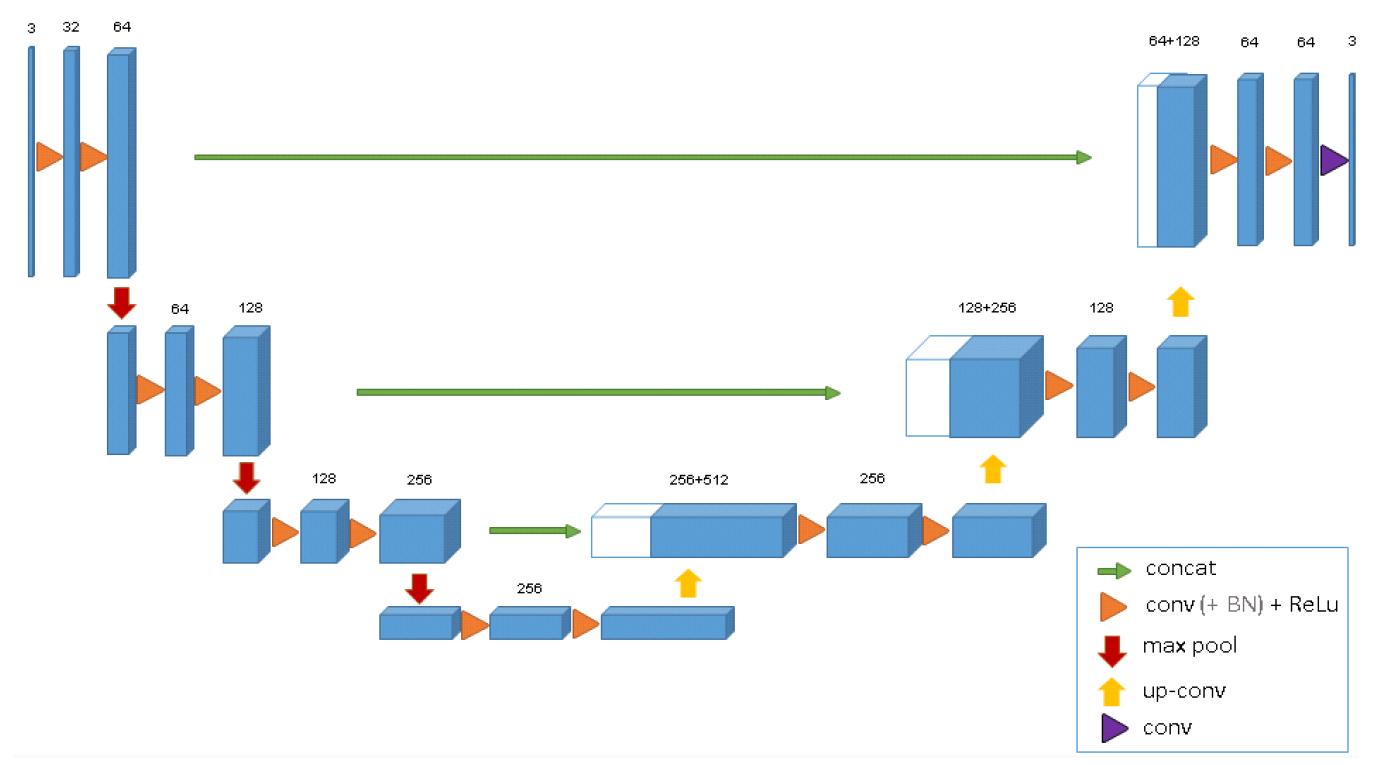

In [ ]:
model = nobrainer.models.unet(
    n_classes=1, 
    input_shape=input_shape)

In [ ]:
model.summary()

### Configure the model

This is where you choose the optimizer, the loss function, metrics, and other optional things.

In [ ]:
import tensorflow as tf

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04),
    loss=nobrainer.losses.dice,
    metrics=[nobrainer.metrics.dice]
)

### Train the model

This will be _very_ slow if you do not have a GPU.

#### Training is a cost-benefit between different forces
- learning rate: a lower learning rate will result in slower training, but a high learning rate might destroy the learned weights.
- batch size: a larger batch size is typically better because your model sees more data at once, but larger batch sizes require hardware with more memory. In 3D segmentation, we typically need to use low batch sizes because of memory limitations.
- block shape: larger blocks are typically better, because your model sees more of the data in each block, but larger blocks require more memory.

#### Definitions
- step: one pass forward (and backward) through the model
- batch_size: number of samples your model sees in one step
- epoch: one pass through your training set

Here are the logs from training if you cannot train on your own. Notice that the Dice score increases slowly. The loss is `1 - dice`. A key takeaway from this is that training is iterative and slow.

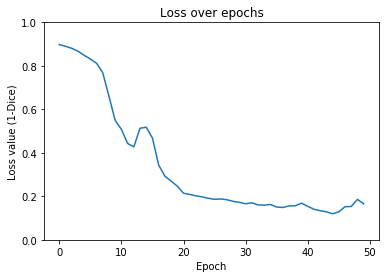


<details>
    Train on 8 samples
    Epoch 1/50
    8/8 [==============================] - 18s 2s/sample - loss: 0.8979 - dice: 0.1021
    Epoch 2/50
    8/8 [==============================] - 6s 757ms/sample - loss: 0.8899 - dice: 0.1101
    Epoch 3/50
    8/8 [==============================] - 6s 757ms/sample - loss: 0.8808 - dice: 0.1192
    Epoch 4/50
    8/8 [==============================] - 6s 757ms/sample - loss: 0.8673 - dice: 0.1327
    Epoch 5/50
    8/8 [==============================] - 6s 757ms/sample - loss: 0.8487 - dice: 0.1513
    Epoch 6/50
    8/8 [==============================] - 6s 760ms/sample - loss: 0.8314 - dice: 0.1686
    Epoch 7/50
    8/8 [==============================] - 6s 762ms/sample - loss: 0.8121 - dice: 0.1879
    Epoch 8/50
    8/8 [==============================] - 6s 763ms/sample - loss: 0.7683 - dice: 0.2317
    Epoch 9/50
    8/8 [==============================] - 6s 762ms/sample - loss: 0.6592 - dice: 0.3408
    Epoch 10/50
    8/8 [==============================] - 6s 766ms/sample - loss: 0.5488 - dice: 0.4512
    Epoch 11/50
    8/8 [==============================] - 6s 763ms/sample - loss: 0.5081 - dice: 0.4919
    Epoch 12/50
    8/8 [==============================] - 6s 766ms/sample - loss: 0.4432 - dice: 0.5568
    Epoch 13/50
    8/8 [==============================] - 6s 763ms/sample - loss: 0.4276 - dice: 0.5724
    Epoch 14/50
    8/8 [==============================] - 6s 770ms/sample - loss: 0.5131 - dice: 0.4869
    Epoch 15/50
    8/8 [==============================] - 6s 764ms/sample - loss: 0.5177 - dice: 0.4823
    Epoch 16/50
    8/8 [==============================] - 6s 767ms/sample - loss: 0.4676 - dice: 0.5324
    Epoch 17/50
    8/8 [==============================] - 6s 762ms/sample - loss: 0.3437 - dice: 0.6563
    Epoch 18/50
    8/8 [==============================] - 6s 763ms/sample - loss: 0.2927 - dice: 0.7073
    Epoch 19/50
    8/8 [==============================] - 6s 762ms/sample - loss: 0.2700 - dice: 0.7300
    Epoch 20/50
    8/8 [==============================] - 6s 759ms/sample - loss: 0.2469 - dice: 0.7531
    Epoch 21/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.2139 - dice: 0.7861
    Epoch 22/50
    8/8 [==============================] - 6s 755ms/sample - loss: 0.2087 - dice: 0.7913
    Epoch 23/50
    8/8 [==============================] - 6s 755ms/sample - loss: 0.2023 - dice: 0.7977
    Epoch 24/50
    8/8 [==============================] - 6s 755ms/sample - loss: 0.1975 - dice: 0.8025
    Epoch 25/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1908 - dice: 0.8092
    Epoch 26/50
    8/8 [==============================] - 6s 761ms/sample - loss: 0.1864 - dice: 0.8136
    Epoch 27/50
    8/8 [==============================] - 6s 761ms/sample - loss: 0.1878 - dice: 0.8122
    Epoch 28/50
    8/8 [==============================] - 6s 759ms/sample - loss: 0.1842 - dice: 0.8158
    Epoch 29/50
    8/8 [==============================] - 6s 758ms/sample - loss: 0.1767 - dice: 0.8233
    Epoch 30/50
    8/8 [==============================] - 6s 757ms/sample - loss: 0.1723 - dice: 0.8277
    Epoch 31/50
    8/8 [==============================] - 6s 755ms/sample - loss: 0.1657 - dice: 0.8343
    Epoch 32/50
    8/8 [==============================] - 6s 758ms/sample - loss: 0.1702 - dice: 0.8298
    Epoch 33/50
    8/8 [==============================] - 6s 761ms/sample - loss: 0.1604 - dice: 0.8396
    Epoch 34/50
    8/8 [==============================] - 6s 760ms/sample - loss: 0.1594 - dice: 0.8406
    Epoch 35/50
    8/8 [==============================] - 6s 759ms/sample - loss: 0.1625 - dice: 0.8375
    Epoch 36/50
    8/8 [==============================] - 6s 757ms/sample - loss: 0.1506 - dice: 0.8494
    Epoch 37/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1488 - dice: 0.8512
    Epoch 38/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1558 - dice: 0.8442
    Epoch 39/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1565 - dice: 0.8435
    Epoch 40/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1683 - dice: 0.8317
    Epoch 41/50
    8/8 [==============================] - 6s 757ms/sample - loss: 0.1540 - dice: 0.8460
    Epoch 42/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1405 - dice: 0.8595
    Epoch 43/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1339 - dice: 0.8661
    Epoch 44/50
    8/8 [==============================] - 6s 760ms/sample - loss: 0.1288 - dice: 0.8712
    Epoch 45/50
    8/8 [==============================] - 6s 760ms/sample - loss: 0.1197 - dice: 0.8803
    Epoch 46/50
    8/8 [==============================] - 6s 758ms/sample - loss: 0.1284 - dice: 0.8716
    Epoch 47/50
    8/8 [==============================] - 6s 761ms/sample - loss: 0.1523 - dice: 0.8477
    Epoch 48/50
    8/8 [==============================] - 6s 756ms/sample - loss: 0.1531 - dice: 0.8469
    Epoch 49/50
    8/8 [==============================] - 6s 754ms/sample - loss: 0.1858 - dice: 0.8142
    Epoch 50/50
    8/8 [==============================] - 6s 753ms/sample - loss: 0.1658 - dice: 0.8342
</details>

In [ ]:
history = model.fit(
    x=x_blocks, 
    y=y_blocks, 
    batch_size=2, 
    epochs=50)

In [ ]:
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss value (1-Dice)")
plt.ylim(0, 1)
plt.title("Loss over epochs")
plt.show()

### Try out the model on a new scan

We _MUST_ process our new scan in the same way as we processed the training data.

Here are the outputs if you were not able to train the model yourself

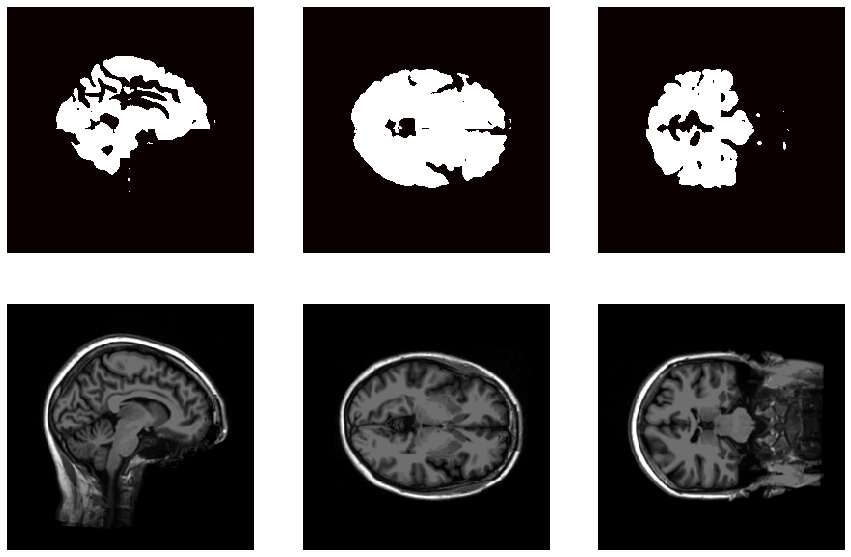

In [ ]:
pair_of_filepaths = filepaths[1]
xtest = nobrainer.io.read_volume(pair_of_filepaths[0])
ytest = nobrainer.io.read_volume(pair_of_filepaths[1])

xtest = nobrainer.volume.standardize_numpy(xtest)
xtest_blocks = nobrainer.volume.to_blocks_numpy(xtest, block_shape)
xtest_blocks = np.expand_dims(xtest_blocks, axis=-1)

In [ ]:
y_ = model.predict(xtest_blocks, batch_size=1, verbose=1)

In [ ]:
y_.shape

In [ ]:
# These outputs are probabilities
# So we apply a threshold.
# >= 50% is brain, otherwise it's background

In [ ]:
# This creates a boolean array (values are True or False)
brainmask = y_ > 0.5

In [ ]:
# Remove the last dimension.
brainmask = np.squeeze(brainmask, axis=-1)

In [ ]:
brainmask.shape

In [ ]:
brainmask = nobrainer.volume.from_blocks_numpy(brainmask, output_shape=(256, 256, 256))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
# Remove axis ticks and labels
for ax in axes:
    ax.axis(False)
axes[0].matshow(brainmask[120], cmap="hot")
axes[1].matshow(brainmask[:, 120], cmap="hot")
axes[2].matshow(brainmask[:, :, 120], cmap="hot")
axes[3].matshow(xtest[120], cmap="gray")
axes[4].matshow(xtest[:, 120], cmap="gray")
axes[5].matshow(xtest[:, :, 120], cmap="gray")
plt.show()

Evaluate the model's performance using Dice score.

Is 0.89 for me. Decent!

In [ ]:
ytest_brainmask = ytest > 0

nobrainer.metrics.dice(
    y_true=ytest_brainmask.astype("float32"), 
    y_pred=brainmask.astype("float32"), 
    axis=(0, 1, 2))

# Lessons so far

- Understand your data (visualize your features and labels)
- Training is slow
- Models do not generalize well

# Recommentation

If possible, begin with a model that was trained on lots of data.

# Pre-trained models

**Nobrainer has pre-trained 3D models.** Lots of 2D models pre-trained models exist, but very few 3D.

In [ ]:
pretrained_model_path = tf.keras.utils.get_file(
    fname='brain-extraction-unet-128iso-model.h5',
    origin='https://github.com/neuronets/nobrainer-models/releases/download/0.1/brain-extraction-unet-128iso-model.h5')

pretrained_model = tf.keras.models.load_model(pretrained_model_path, compile=False)

In [ ]:
pair_of_filepaths = filepaths[1]
xtest = nobrainer.io.read_volume(pair_of_filepaths[0])
ytest = nobrainer.io.read_volume(pair_of_filepaths[1])

xtest = nobrainer.volume.standardize_numpy(xtest)
xtest_blocks = nobrainer.volume.to_blocks_numpy(xtest, block_shape=(128, 128, 128))
xtest_blocks = np.expand_dims(xtest_blocks, axis=-1)

## Predict using the pre-trained brain extraction model

Here we are harnessing the knowledge learned by the model from 10,000 different brain scans.

The prediction takes about a minute to run. If you cannot run it, here are the outputs.

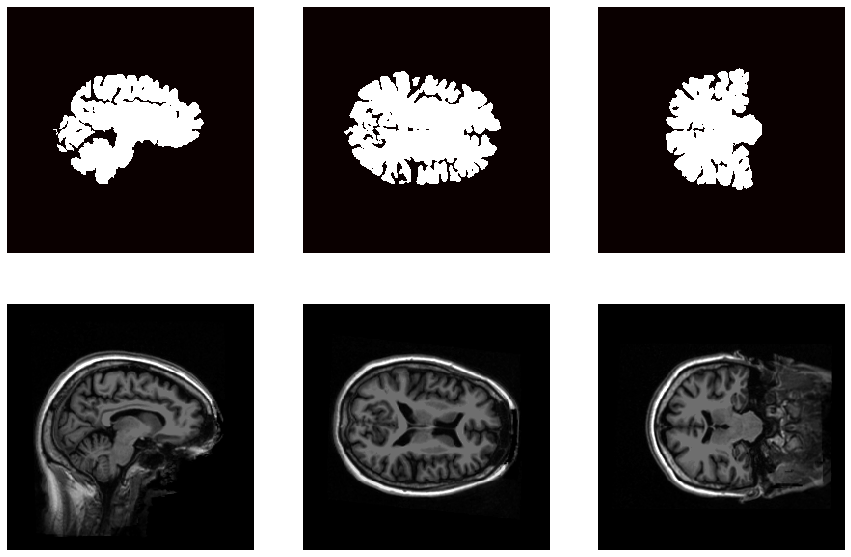

In [ ]:
pretrained_outputs = pretrained_model.predict(xtest_blocks, batch_size=1, verbose=1)

In [ ]:
pretrained_outputs_binary = pretrained_outputs > 0.5
pretrained_outputs_binary = pretrained_outputs_binary.squeeze(-1)
brainmask = nobrainer.volume.from_blocks_numpy(pretrained_outputs_binary, (256, 256, 256))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
# Remove axis ticks and labels
for ax in axes:
    ax.axis(False)
axes[0].matshow(y[120], cmap="hot")
axes[1].matshow(y[:, 120], cmap="hot")
axes[2].matshow(y[:, :, 120], cmap="hot")
axes[3].matshow(x[120], cmap="gray")
axes[4].matshow(x[:, 120], cmap="gray")
axes[5].matshow(x[:, :, 120], cmap="gray")
plt.show()

### Assess our performance

Dice coefficient is a popular metric of similarity.

Dice score is 0.95604503. MUCH better than what we had, and without any training :)

In [ ]:
ytest_brainmask = ytest > 0

nobrainer.metrics.dice(
    y_true=ytest_brainmask.astype("float32"), 
    y_pred=brainmask.astype("float32"), 
    axis=(0, 1, 2))

## Predict using the pre-trained brain segmentation model

Here we are harnessing the knowledge learned by the model from over 20,000 different brain scans. This is also a Bayesian model, which can tell us how confident the model is of its own predictions.

This model is published in https://doi.org/10.3389/fninf.2019.00067

Code is available at https://github.com/neuronets/kwyk

**This section takes about five minutes to run on a CPU. Let's skip for now, but here is the output...**

This is a subset of FreeSurfer `recon-all` outputs. The major benefit is that you get estimates of confidence and segmentation takes minutes as opposed to hours. However, this has not been validated yet as a tool safe to use in analyses. This is still experimental.

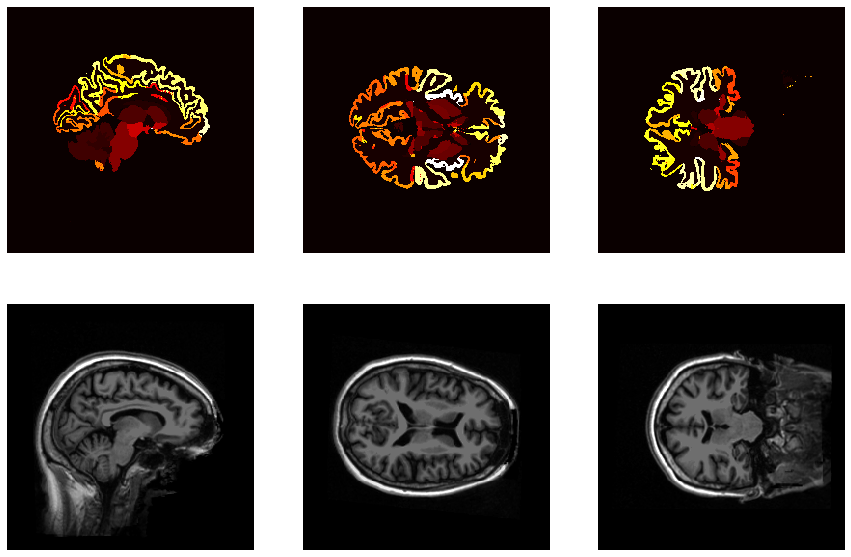

In [ ]:
from nobrainer.models.bayesian import variational_meshnet

segmentation_model = variational_meshnet(
    n_classes=50, 
    input_shape=(32, 32, 32, 1),
    filters=96, 
    dropout="concrete", 
    receptive_field=37, 
    is_monte_carlo=True)

In [ ]:
weights_path = tf.keras.utils.get_file(
    fname="nobrainer_spikeslab_32iso_weights.h5",
    origin="https://dl.dropbox.com/s/rojjoio9jyyfejy/nobrainer_spikeslab_32iso_weights.h5")

segmentation_model.load_weights(weights_path)

In [ ]:
pair_of_filepaths = filepaths[1]
xtest = nobrainer.io.read_volume(pair_of_filepaths[0])
ytest = nobrainer.io.read_volume(pair_of_filepaths[1])

xtest = nobrainer.volume.standardize_numpy(xtest)
xtest_blocks = nobrainer.volume.to_blocks_numpy(xtest, block_shape=(32, 32, 32))
xtest_blocks = np.expand_dims(xtest_blocks, axis=-1)

In [ ]:
# One a 1080Ti GPU, this takes 16 seconds. On an i7 CPU, this takse 5 minutes.
segmentation_outputs = segmentation_model.predict(xtest_blocks, batch_size=1, verbose=1)

In [ ]:
# Shape is (512, 32, 32, 32, 50)
# 512 blocks
# 50 classes
segmentation_outputs.shape

In [ ]:
# Argmax returns the index of the max value. 
# So if the max probability is in index 3, then the class is 3.
segmentation_outputs_classes = segmentation_outputs.argmax(axis=-1)
segmentation_outputs_classes = nobrainer.volume.from_blocks_numpy(
    segmentation_outputs_classes, (256, 256, 256))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
# Remove axis ticks and labels
for ax in axes:
    ax.axis(False)
axes[0].matshow(segmentation_outputs_classes[120], cmap="hot")
axes[1].matshow(segmentation_outputs_classes[:, 120], cmap="hot")
axes[2].matshow(segmentation_outputs_classes[:, :, 120], cmap="hot")
axes[3].matshow(x[120], cmap="gray")
axes[4].matshow(x[:, 120], cmap="gray")
axes[5].matshow(x[:, :, 120], cmap="gray")
plt.show()

# The above is great ...

We learned how to process our data, instantiate a deep neural network architecture, train our model, and predict. We even learned how to use a pre-trained model. This works well for learning the basics, debugging, and predicting on a few scans.


# ... but it does not scale.

- If you are training on any respectable amount of data, you will most likely not be able to fit it in memory.
- Performing augmentation during training is important, but its not clear how to do that with what we learned so far.
- We don't want to load, then process, then train. Would rather load, process, and train in an interleaved fashion, so our CPU and GPU are never idle.
    - If you are using paid cloud services, it is especially important to optimize how you spend your time.

# Real-world workflow

This details the steps for segmentation. Classification and regression are also possible (the labels would be scalars instead of volumetric).

1. Prepare data on disk
    1. Create a spreadsheet of pairs of features and labels. These are paths to the corresponding MRI files.
    2. Separate all of your data into three sets: training, validation, testing
        - Train with the training set
        - Validate (during training) with the validation set
        - Evaluate the model after training on the testing set
    3. Convert the data into TFRecord format. 
        - This format is TensorFlow's preferred data format for data that does not fit into memory. This format allows for parallel reading.
2. Create a processing pipeline (or more precisely, a preprocessing graph)
    1. Load data from disk
    1. Standardize features
    2. Prepare labels
        - For binary classification, binarize the labels so they are 0 or 1.
        - For multi-class classification, map your labels to values in `[0, n_classes-1]`.
    3. Optionally add augmentation
        - Add Gaussian noise, apply random rigid transformation, etc.
        - This can lead to more generalizable models.
3. Choose a loss function (and metrics)
4. Choose a model
    - **Try to find a pre-trained model that suits your needs**
    - Instantiate the model from Nobrainer
    - Or create the model yourself using the [`tf.keras` API](https://www.tensorflow.org/guide/keras/overview)
5. Train (and validate at the end of each epoch)
    - This is an iterative process. To improve your 
6. Evaluate model on testing set

## 1. Preparing training data

In this tutorial, we will convert medical imaging data to the TFRecords format. Having data in the TFRecords format speeds up training and allows us to use standard, highly-optimized TensorFlow I/O methods. We will then create a `tf.data.Dataset` object using the TFRecords data. This `tf.data.Dataset` object can be used for training, evaluation, or prediction.

This tutorial will use publicly available data. To convert your own data, you will need to create a nested list of features and labels volumes. One can store this as a CSV that looks like the following:

```
features,labels
/path/to/1_features.nii.gz,/path/to/1_labels.nii.gz
/path/to/2_features.nii.gz,/path/to/2_labels.nii.gz
/path/to/3_features.nii.gz,/path/to/3_labels.nii.gz
/path/to/4_features.nii.gz,/path/to/4_labels.nii.gz
```


You can read this CSV in Python with `nobrainer.io.read_csv`.

## Google Colaboratory

If you are using Colab, please switch your runtime to GPU. To do this, select `Runtime > Change runtime type` in the top menu. Then select GPU under `Hardware accelerator`. A GPU is not necessary to prepare the data, but a GPU is helpful for training a model, which we demonstrate at the end of this notebook.


## Get sample data

Here, we download 10 T1-weighted brain scans and their corresponding FreeSurfer segmentations. These volumes take up about 46 MB and are saved to a temporary directory. The object `csv_path` is the path to a CSV file. Each row of this CSV file contains the paths to a pair of features and labels volumes.

In [ ]:
csv_of_filepaths = nobrainer.utils.get_data()
filepaths = nobrainer.io.read_csv(csv_of_filepaths)

# For model training (this is the data the model will learn from).
train_paths = filepaths[:7]
# For evaluating the model during the training process.
# We can change hyperparameters like batch size, learning rate, etc and see the effect on the validation.
validation_paths = filepaths[7:9]
# For evaluating the final model on unseen data.
test_paths = filepaths[9:]

In [ ]:
# Verify that all volumes have the same shape and that labels are integer-ish.

invalid = nobrainer.io.verify_features_labels(train_paths)
assert not invalid

invalid = nobrainer.io.verify_features_labels(validation_paths)
assert not invalid

invalid = nobrainer.io.verify_features_labels(test_paths)
assert not invalid

## Convert to volume files to TFRecords

To achieve the best performance, training data should be in TFRecords format. This is the preferred file format for TensorFlow, Training can be done on medical imaging volume files but will be slower.

Nobrainer has a command-line utility to convert volumes to TFRecords: `nobrainer convert`. This will verify that all of the volumes have the same shape and that the label volumes are an integer type or can be safely coerced to an integer type. 

Following successful verification, the volumes will be converted to TFRecords files. The dataset should be sharded into multiple TFRecords files, so that data can be shuffled more properly. This is especially helpful for large datasets. Users can choose how many pairs of volumes (i.e., features and labels) will be saved to one TFRecords file. In this example, we will save 3 pairs of volumes per TFRecords file because our dataset is small. With a larger dataset, users should choose a larger shard value. For example, with 10,000 volumes, one might choose 100 volumes per TFRecords file.

In [ ]:
import os

os.makedirs("data", exist_ok=True)

# Convert training and evaluation data to TFRecords.

nobrainer.tfrecord.write(
    features_labels=train_paths,
    filename_template='data/data-train_shard-{shard:03d}.tfrec',
    examples_per_shard=3)

nobrainer.tfrecord.write(
    features_labels=validation_paths,
    filename_template='data/data-validation_shard-{shard:03d}.tfrec',
    examples_per_shard=1)

nobrainer.tfrecord.write(
    features_labels=test_paths,
    filename_template='data/data-test_shard-{shard:03d}.tfrec',
    examples_per_shard=1)

In [ ]:
os.listdir("data")

# 2. Create input data pipeline

We will now create an data pipeline to feed our models with training data. The steps below will create a `tensorflow.data.Dataset` object that is built according to [TensorFlow's guidelines](https://www.tensorflow.org/guide/performance/datasets). The basic pipeline is summarized below.

- Read data
- Separate volumes into non-overlapping sub-volumes
    - This is done to get around memory limitations with larger models.
    - For example, a volume with shape (256, 256, 256) can be separated into eight non-overlapping blocks of shape (128, 128, 128).
- Apply random rigid augmentations if requested.
- Standard score volumes of features.
- Binarize labels if binary segmentation.
- Replace values according to some mapping if multi-class segmentation.
- Batch the results so every iteration yields `batch_size` elements.

In [ ]:
# The number of classes the model predicts. A value of 1 means the model performs
# binary classification (i.e., target vs background).
n_classes = 1

# Batch size is the number of features and labels we train on with each step.
batch_size = 2

# The shape of the original volumes.
volume_shape = (256, 256, 256)

# The shape of the non-overlapping sub-volumes. Most models cannot be trained on
# full volumes because of hardware and memory constraints, so we train and evaluate
# on sub-volumes.
block_shape = (128, 128, 128)

# Whether or not to apply random rigid transformations to the data on the fly.
# This can improve model generalizability but increases processing time.
augment = False

# Number of epochs for which to repeat the dataset.
n_epochs = 5

# The tfrecords filepaths will be shuffled before reading, but we can also shuffle
# the data. This will shuffle 10 volumes at a time. Larger buffer sizes will require
# more memory, so choose a value based on how much memory you have available.
shuffle_buffer_size = 10

# Number of parallel processes to use. Let tensorflow figure it out...
num_parallel_calls = tf.data.experimental.AUTOTUNE

In [ ]:
dset_train = nobrainer.dataset.get_dataset(
    file_pattern="data/data-train_shard-*.tfrec",
    n_classes=n_classes,
    batch_size=batch_size,
    volume_shape=volume_shape,
    block_shape=block_shape,
    augment=augment,
    n_epochs=1,  # Set this to 1 because `model.fit` will repeat on its own.
    shuffle_buffer_size=shuffle_buffer_size,
    num_parallel_calls=num_parallel_calls)

In [ ]:
dset_validation = nobrainer.dataset.get_dataset(
    file_pattern="data/data-validation_shard-*.tfrec",
    n_classes=n_classes,
    batch_size=batch_size,
    volume_shape=volume_shape,
    block_shape=block_shape,
    augment=False,
    n_epochs=1,
    shuffle_buffer_size=None,
    num_parallel_calls=num_parallel_calls)

In [ ]:
dset_test = nobrainer.dataset.get_dataset(
    file_pattern="data/data-test_shard-*.tfrec",
    n_classes=n_classes,
    batch_size=batch_size,
    volume_shape=volume_shape,
    block_shape=block_shape,
    augment=False,
    n_epochs=1,
    shuffle_buffer_size=None,
    num_parallel_calls=num_parallel_calls)

# 3. Choose a loss function

Many options... Dice, Jaccard, Tversky, cross-entropy, and many others.

See `nobrainer.losses` and please submit an [issue](https://github.com/neuronets/nobrainer/issues/new/choose) or [pull request](https://github.com/neuronets/nobrainer/pulls) if you run into issues or want to add functionality.

# 4. Choose a model

Even more options than loss functions. Nobrainer has several implementations, including U-Net, MeshNet, Bayesian U-Net, and Highresnet.

**If possible, use a pre-trained model. This is especially important if you do not have much data.**

If you need to train a model from scratch, a good heuristic for choosing an architecture is to look at segmentation challenges (like MICCAI BraTS) and see what performed well.

See https://github.com/neuronets/nobrainer-models#brain-extraction for information about the pre-trained model.

>This model achieved a median Dice score of 0.97, mean of 0.96, minimum of 0.91, and maximum of 0.98 on a validation dataset of 99 T1-weighted brain scans and their corresponding binarized FreeSurfer segmentations (public and private sources). This model should be agnostic to orientation and can predict the brainmask for a volume of size 256x256x256 in approximately three seconds. The model was trained on 10,000 brain scans.

In [ ]:
model_path = tf.keras.utils.get_file(
    fname='brain-extraction-unet-128iso-model.h5',
    origin='https://github.com/neuronets/nobrainer-models/releases/download/0.1/brain-extraction-unet-128iso-model.h5')

model = tf.keras.models.load_model(model_path, compile=False)

## Considerations for transfer learning

Training a neural network changes the model's weights. A pre-trained network has learned weights for a task, and we do not want to forget these weights during training. In other words, we do not want to ruin the pre-trained weights when using our new data. To avoid dramatic changes in the learnable parameters, we can apply regularization and use a relatively small learning rate.

In [ ]:
for layer in model.layers:
    layer.kernel_regularizer = tf.keras.regularizers.l2(0.001)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

model.compile(
    optimizer=optimizer,
    loss=nobrainer.losses.jaccard,
    metrics=[nobrainer.metrics.dice])

# 5. Train

Notes: during the first epoch, the number of steps will be unknown (`tf.data.Dataset` does not know how many steps it contains), but it figures it out after the first epoch. 

In this case, each epoch is 28 steps. 

$$
steps = \frac{nBlocks}{volume} * \frac{nVolumes}{batchSize} = \frac{8}{1} * \frac{7}{2}
$$

In [ ]:
history = model.fit(
    dset_train,
    validation_data=dset_validation,
    epochs=n_epochs)

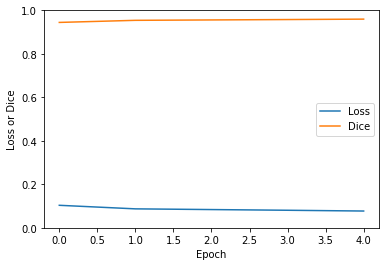

In [ ]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["dice"], label="Dice")
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Loss or Dice")
plt.legend()
plt.show()

# 6. Evaluate

Calculate Dice score on an unseen scan.

Output:

```
      4/Unknown - 3s 627ms/step - loss: 0.0888 - dice: 0.9532
```

In [ ]:
output = model.evaluate(dset_test)